# Code to export RGB images

# Initialize and Authenticate

In [ ]:
# AUTHENTICATE to EARTH ENGINE using your individual Google Earth account credentials
!earthengine authenticate 

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=wcYQzfuoXlmU7k6hgWThl8lEQhYLR4bf9AjnZRslcUk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5TnRDs9woE14Ndz6bge5uAvry4MvM6gTXQgUnL2Ao084cgaYzNoxk

Successfully saved authorization token.


In [ ]:
# IMPORT & INITIALIZE ee library
import time
import ee
ee.Initialize()

In [ ]:
# AUTHENTICATE to Google Colab
from google.colab import auth
auth.authenticate_user()

In [ ]:
# IMPORT & MOUNT gDrive so we can access the .csv with CWA determinations
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Python packages

In [ ]:
from IPython.display import Image
import pandas as pd
import numpy as np

import os
from osgeo import gdal
import matplotlib.pyplot as plt

import time

# Initialize Global Variables

AOI: ee.Geometry Area of interest  
START_DATE: string Image collection start date (inclusive)  
END_DATE: string Image collection end date (exclusive)  
CLOUD_FILTER: integer Maximum image cloud cover percent allowed in image collection  
BUFFER: integer Distance (m) to dilate the edge of cloud-identified objects  

In [ ]:
center_lat = 41.84
center_lon = -88.27

crs_proj = "EPSG:4326"

# Define date range for image extraction (modify to suit need)
# START_DATE = '2018-08-01'
# END_DATE = '2019-08-01'
START_DATE = '2018-08-01'
END_DATE = '2020-04-01'

# Define cloud mask parameter
CLOUD_FILTER = 10

# DEFINE BUCKET & FOLDER
BUCKET = 'pollutemenot-ai'
FOLDER = "Rad_Experiment_1"


# PART 1

## Step-by-step workflow

Load Sentinel 2 Image Collection

In [ ]:
sentinel_2 = ee.ImageCollection("COPERNICUS/S2_SR")

Define area of interest (AOI)

In [ ]:
# For HiRes image
# A buffer size of 1000 corresponds to a circle of radius 1000m that is bounded by a square of side 2500m or 2.5km
AOI = ee.Geometry.Point([center_lon, center_lat], proj=crs_proj).buffer(1000).bounds()

# For LoRes image
# A buffer size of 10000 corresponds to a circle of radius 10000m that is bounded by a square of side 25000m or 25km
#AOI = ee.Geometry.Point([center_lon, center_lat], proj=crs_proj).buffer(10000).bounds()

Extract image of AOI

In [ ]:
img_aoi = sentinel_2.filterBounds(AOI) \
 .filterDate(START_DATE, END_DATE) \
 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CLOUD_FILTER)) \
 .sort('CLOUDY_PIXEL_PERCENTAGE') \
 .first() \
 .clip(AOI)\
 .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

# To test for success, print band names of the extracted image
img_aoi.bandNames().getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

View the extracted image

In [ ]:
display_img = img_aoi.select('B4','B3','B2')
img_url = display_img.getThumbUrl({'min': 10, 'max': 2000, 'dimensions': 256}) # https://developers.google.com/earth-engine/apidocs/ee-data-getmapid
# img_url = img_aoi.getThumbUrl({'bands':('B4','B3','B2'), 'min': 10, 'max': 3000, 'dimensions': 256})
print(img_url)
Image(url=img_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/83b32f41ca9a2d7311823880b1a162ce-51b068df146b204b7a8cd00cef356e2d:getPixels


Extract RGB image

In [ ]:
img_RGB = img_aoi.select('B4', 'B3', 'B2')
# img_RGB.getInfo()['bands']
img_RGB.bandNames().getInfo()

['B4', 'B3', 'B2']

View RGB image

In [ ]:
img_url = img_RGB.getThumbUrl({'min': 10, 'max': 3000, 'dimensions': 256})
print(img_url)
Image(url=img_url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32d8e37345d74aa6e0a297379f3b6c6e-139d86a59a9d01dac7e32f732188e4e6:getPixels


Export RGB image to GCS

In [ ]:
task = ee.batch.Export.image.toCloudStorage(
      image = img_RGB,
      description = "test",
      bucket = BUCKET,
      fileNamePrefix = FOLDER + '/' + "hires" + '/' + "RGB" + '/' + "test" + '_' + "RGB" + '_' + "hires",
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
task.start()
 
# Block until the task completes.
while task.active():
  time.sleep(30)

# Error condition
if task.status()['state'] != 'COMPLETED':
  print('Error with image export.')
else:
  pass


View exported image

In [ ]:
# download image from GCS to gDrive
!gsutil -m cp -r gs://pollutemenot-ai/Rad_Experiment_1/hires/RGB /content/drive/My\ Drive/Colab\ Notebooks/Images

# verify that image has been downloaded
local_download_path = r"/content/drive/My Drive/Colab Notebooks/Images/RGB/"
for filename in os.listdir(local_download_path):
    if filename.endswith("tif"): 
        print(filename)       

Number of channels in image: 3


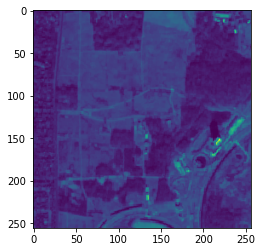

In [ ]:
# display images using gdal
local_download_path = r"/content/drive/My Drive/Colab Notebooks/Images/RGB/"
ds = gdal.Open(local_download_path + 'test_RGB_hires.tif', gdal.GA_ReadOnly)
#ds = gdal.Open(local_download_path + '9001_SAC-2017-00917_RGB_hires.tif', gdal.GA_ReadOnly)

rb = ds.GetRasterBand(1)
img_array = rb.ReadAsArray()
plt.imshow(img_array)

print("Number of channels in image:",ds.RasterCount)

# PART 2

### Function to Extract RGB image

In [ ]:
def extract_RGB_img(center_lat, center_lon, size=1000):
  
  sentinel_2 = ee.ImageCollection("COPERNICUS/S2_SR")
  
  AOI = ee.Geometry.Point(center_lon,center_lat).buffer(size).bounds()
  
  image_aoi = (sentinel_2.filterBounds(AOI) \
  .filterDate(START_DATE, END_DATE) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',CLOUD_FILTER)) \
  .sort('CLOUDY_PIXEL_PERCENTAGE') \
  .first() \
  .clip(AOI) \
  .select(['B4', 'B3', 'B2']))
  
  return image_aoi


Test function

In [ ]:
# img_aoi_RGB = extract_RGB_img(41.84, -88.27, 1000)
img_aoi_RGB = extract_RGB_img(41.84, -88.27, 10000)
img_url = img_aoi_RGB.getThumbUrl({'min': 10, 'max': 3000, 'dimensions': 256})
print(img_url)
print("Image has the following bands:",img_aoi_RGB.bandNames().getInfo())
Image(url=img_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81e947df96b7188f894f49b5fbf703a2-a7e9033401d6ae7c6776dd528b0d8455:getPixels
Image has the following bands: ['B4', 'B3', 'B2']


### Function to Export RGB Image to GCS 

In [ ]:
def doExport_RGB_gcs(lat, lon, index_danum, size=1000, band='RGB'):
  
  image_RGB = extract_RGB_img(lat, lon, size)
     
  if size == 1000:
    size_ = "hires"
  else:
    size_ = "lores"
    
  task = ee.batch.Export.image.toCloudStorage(
      image = image_RGB,
      description = index_danum,
      bucket = BUCKET,
      fileNamePrefix = FOLDER + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()
 
  # Block until the task completes.
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  

Test function

Number of channels in image: 3


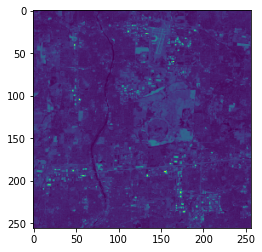

In [ ]:
# perform export
# doExport_RGB_gcs(center_lat, center_lon, 'test5', 1000, 'RGB')
# doExport_RGB_gcs(center_lat, center_lon, 'test5', 10000, 'RGB')

# download exported image to gDrive
# !gsutil -m cp -r gs://pollutemenot-ai/Rad_Experiment_1/hires/RGB /content/drive/My\ Drive/Colab\ Notebooks/Images
# !gsutil -m cp -r gs://pollutemenot-ai/Rad_Experiment_1/lores/RGB /content/drive/My\ Drive/Colab\ Notebooks/Images

# # display images using gdal
local_download_path = r"/content/drive/My Drive/Colab Notebooks/Images/RGB/"

# ds = gdal.Open(local_download_path + 'test5_RGB_hires.tif', gdal.GA_ReadOnly)
ds = gdal.Open(local_download_path + 'test5_RGB_lores.tif', gdal.GA_ReadOnly)

rb = ds.GetRasterBand(1)
img_array = rb.ReadAsArray()
plt.imshow(img_array)

print("Number of channels in image:",ds.RasterCount)

### Function to Export RGB image as Asset

In [ ]:
def doExport_RGB_asset(lat, lon, index_danum, size=1000, band='RGB'):
  
  image_RGB = extract_RGB_img(lat, lon, size)
     
  if size == 1000:
    size_ = "hires"
  else:
    size_ = 'lores'
  
  task = ee.batch.Export.image.toAsset(
      image = image_RGB,
      description = index_danum,
      assetId = 'users/radsatapathy/'+ index_danum + '_' + band + '_' + size_, # make sure the path reflects your Google Earth user id (ex. mine is 'radsatapathy')
      dimensions = "256x256",
      crs = 'EPSG:4326'
      )
  task.start()
 
  # Block until the task completes.
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  

Test export to asset

In [ ]:
# perform export
doExport_RGB_asset(center_lat, center_lon, 'test2', size=1000, band='RGB')
doExport_RGB_asset(center_lat, center_lon, 'test2', size=10000, band='RGB')

*** Visually inspect image in Code Editor

# PART 4


### Wrapper functions for serializing image exports

In [ ]:
def export_data_gcs(index_danum, center_lat, center_lon):
  for size in [1000, 10000]:
    doExport_RGB_gcs(center_lat, center_lon, index_danum, size, "RGB")
    # doExport_index(lat, lon, index_danum, size=1000, band='ndvi')
    # doExport_index(lat, lon, index_danum, size=1000, band='ndwi')
    # doExport_index(lat, lon, index_danum, size=1000, band='mndvi')
    # doExport_index(lat, lon, index_danum, size=1000, band='mndwi')
    # doExport_index(lat, lon, index_danum, size=1000, band='gmnndwi')
    # doExport_srtm(lat, lon, index_danum, size=1000, band="elevation")
    # doExport_srtm(lat, lon, index_danum, size=1000, band="slope")
    # doExport_jrc(lat, lon, index_danum, size=1000, band="seasonality")
    # doExport_jrc(lat, lon, index_danum, size=1000, band="transition")

In [ ]:
def export_data_asset(index_danum, center_lat, center_lon):
  for size in [1000, 10000]:
    doExport_RGB_asset(center_lat, center_lon, index_danum, size, "RGB")

### Split input records

In [ ]:
# Assigned begin and end of records for each person
# MADHUKAR: records 1 - 4000
# SHOBHA: records 4000 - 8000
# RADHIKA: records 8000 - 12000
# JOE: 12000 - last

# datapath = "Data_combined_regular_clean.csv"
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/2021.03.09_ssurgo_nhd_merged.csv")

names = ["MADHUKAR", 'SHOBHA', 'RADHIKA', 'JOE']
start = [1, 4000, 8000, 12000]
end = [4000, 8000, 12000, df.shape[0]]
MY_NAME = "RADHIKA"

# column name 'index' is conflicting with the native index of dataframe
# hence, creating a new column named "Index"
df["Index"] = df.index + 1
start_dict = dict(zip(names, start))
end_dict = dict(zip(names, end))

### Kickoff export to GCS

In [ ]:
index_begin = 9000
index_end = 9010

if index_begin >= start_dict[MY_NAME] and index_end <= end_dict[MY_NAME]:
  for count in range(index_begin, index_end):
    if count == index_begin: print("download started from index =", count)
    da_number = df.iloc[count-1]["da_number"]
    latitude = df.iloc[count-1]["latitude"]
    longitude = df.iloc[count-1]["longitude"]
    index = count
    export_data_gcs(str(index) + '_' + da_number, latitude, longitude)
    print("Done uploading hires and lores of index =", index)
else:
  print("Please ensure the begin and end is within the interval assigned to you")

print("Woohoo all done!")

download started from index = 9000
Done uploading hires and lores of index = 9000
Done uploading hires and lores of index = 9001
Done uploading hires and lores of index = 9002
Done uploading hires and lores of index = 9003
Done uploading hires and lores of index = 9004
Done uploading hires and lores of index = 9005
Done uploading hires and lores of index = 9006
Done uploading hires and lores of index = 9007
Done uploading hires and lores of index = 9008
Done uploading hires and lores of index = 9009
Woohoo all done!


### Kickoff export to asset

In [ ]:
index_begin = 9000
index_end = 9010

if index_begin >= start_dict[MY_NAME] and index_end <= end_dict[MY_NAME]:
  for count in range(index_begin, index_end):
    if count == index_begin: print("download started from index =", count)
    da_number = df.iloc[count-1]["da_number"]
    latitude = df.iloc[count-1]["latitude"]
    longitude = df.iloc[count-1]["longitude"]
    index = count
    export_data_asset(str(index) + '_' + da_number, latitude, longitude)
    print("Done uploading hires and lores of index =", index)
else:
  print("Please ensure the begin and end is within the interval assigned to you")

print("Woohoo all done!")

download started from index = 9000
Done uploading hires and lores of index = 9000
Done uploading hires and lores of index = 9001
Done uploading hires and lores of index = 9002
Done uploading hires and lores of index = 9003
Done uploading hires and lores of index = 9004
Done uploading hires and lores of index = 9005
Done uploading hires and lores of index = 9006
Done uploading hires and lores of index = 9007
Done uploading hires and lores of index = 9008
Done uploading hires and lores of index = 9009
Woohoo all done!


## Kickoff export to GCS for sample set

In [ ]:
# export for sample set 01_1235

BUCKET = 'pollutemenot-ai'
FOLDER = "Sample_Set_12345"

df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/sac_saw_subset_01_1235.csv")

df["Index"] = df.index + 1

index_begin = 2372
index_end = df.shape[0]

for count in range(index_begin, index_end):
  if count == index_begin: 
    print("download started from index =", count)
  da_number = df.iloc[count-1]["da_number"]
  latitude = df.iloc[count-1]["latitude"]
  longitude = df.iloc[count-1]["longitude"]
  index = count
  export_data_gcs(str(index) + '_' + da_number, latitude, longitude)
  print("Done uploading hires and lores of index =", index)

print("Woohoo all done!")

download started from index = 2372
Done uploading hires and lores of index = 2372
Done uploading hires and lores of index = 2373
Done uploading hires and lores of index = 2374
Done uploading hires and lores of index = 2375
Done uploading hires and lores of index = 2376
Done uploading hires and lores of index = 2377
Done uploading hires and lores of index = 2378
Done uploading hires and lores of index = 2379
Done uploading hires and lores of index = 2380
Done uploading hires and lores of index = 2381
Done uploading hires and lores of index = 2382
Done uploading hires and lores of index = 2383
Done uploading hires and lores of index = 2384
Done uploading hires and lores of index = 2385
Done uploading hires and lores of index = 2386
Done uploading hires and lores of index = 2387
Done uploading hires and lores of index = 2388
Done uploading hires and lores of index = 2389
Done uploading hires and lores of index = 2390
Done uploading hires and lores of index = 2391
Done uploading hires and 

KeyboardInterrupt: ignored

In [ ]:
# export for sample set 01_89

BUCKET = 'pollutemenot-ai'
FOLDER = "Sample_Set_89"

df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/sac_saw_subset_01_89.csv")

df["Index"] = df.index + 1

index_begin = 1
index_end = df.shape[0]

for count in range(index_begin, index_end):
  if count == index_begin: 
    print("download started from index =", count)
  da_number = df.iloc[count-1]["da_number"]
  latitude = df.iloc[count-1]["latitude"]
  longitude = df.iloc[count-1]["longitude"]
  index = count
  export_data_gcs(str(index) + '_' + da_number, latitude, longitude)
  print("Done uploading hires and lores of index =", index)

print("Woohoo all done!")

Test using gdal

In [ ]:
# download GCS contents to GDrive
!gsutil -m cp -r gs://pollutemenot-ai/Rad_Experiment_1/hires/RGB /content/drive/My\ Drive/Colab\ Notebooks/Images
!gsutil -m cp -r gs://pollutemenot-ai/Rad_Experiment_1/lores/RGB /content/drive/My\ Drive/Colab\ Notebooks/Images

In [ ]:
# Verify image files in folder
local_download_path = r"/content/drive/My Drive/Colab Notebooks/Images/RGB/"
for filename in os.listdir(local_download_path):
    if filename.endswith("tif"): 
        print(filename)

Number of channels in image: 3


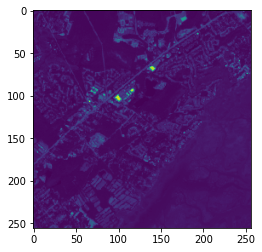

In [ ]:
# display images using gdal
ds = gdal.Open(local_download_path + '9001_SAC-2017-00917_RGB_lores.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
# rb = ds.GetRasterBand(12)
img_array = rb.ReadAsArray()

print("Number of channels in image:",ds.RasterCount)
plt.imshow(img_array)

# PART 3

## Functions to generate spectral index images

Band 1 : Coastal Aerosol  
Band 2 : Blue  
Band 3 : Green  
Band 4 : Red  
Band 8 :  NIR  
Band 11 : SWIR  
 

In [ ]:
# NDWI - Normalized Difference Water Index = (Green-NIR)/(Green+NIR)
def make_ndwi(image, green='B3', nir='B8'):
  return image.normalizedDifference([green, nir])  


# NDVI - Normalized Difference Vegetation Index = (NIR-Red)/(NIR+Red)
def make_ndvi(image, red='B4', nir='B8'):
  return image.normalizedDifference([nir, red])  


# MNDVI - Modified Normalized Vegetation Index = (NIR-Red)/(NIR+Red-2*Aerosol)
def make_mndvi(image, red='B4', nir='B8'):
  nir = image.select('B8')
  red = image.select('B4')
  aerosols = image.select('B1')  
  mndvi = (nir.subtract(red)
                      .divide(nir.add(red)
                      .subtract(aerosols.add(aerosols)))
                      .rename('mndvi'))
  return mndvi


# MNDWI - Modified Normalized Water Index = (Green-SWIR)/(Green +SWIR)
def make_mndwi(image, green='B3', swir='B11'):
  green = image.select('B3')
  swir = image.select('B11')
  mndwi = (green.subtract(swir)
                .divide(green.add(swir))
                .rename('mndwi'))
  return mndwi

## Function to export spectral index images

In [ ]:
def doExport_index(lat, lon, index_danum, size=1000, band='ndvi'):

  if band == 'ndvi':
    image = make_ndvi(lat, lon, size)

  elif band == 'ndwi':
    image = make_ndwi(lat, lon, size)

  elif band == 'mndvi':
    image = make_mndvi(lat, lon, size)

  elif band == 'mndwi':
    image = make_mndwi(lat, lon, size)

  else:
    image = make_gmndwi(lat, lon, size)
  
    
  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'
    
  folder = FOLDER
  
  task = ee.batch.Export.image.toCloudStorage(
      image = image, 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()

  # Block until the task completes.
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  

## Function to extract & export SRTM images

In [ ]:
def doExport_srtm(lat, lon, index_danum, size=1000, band="elevation"):
  
  srtm = ee.Image('USGS/SRTMGL1_003')
  
  AOI = ee.Geometry.Point(center_lon,center_lat).buffer(size).bounds()

  if band == "elevation":
    image = srtm
  else:
    image = ee.Terrain.slope(srtm)

  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'

  folder = FOLDER
  
  task = ee.batch.Export.image.toCloudStorage(
      image = image, 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      crs = 'EPSG:4326',
      region = AOI,
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True  }
      )
  task.start()


  # Block until the task completes.
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  

## Function to extract & export JRC images

In [ ]:
def doExport_jrc(lat, lon, index_danum, size=1000, band="seasonality"):
  
  jrc = ee.Image("JRC/GSW1_2/GlobalSurfaceWater")
  
  AOI = ee.Geometry.Point(center_lon,center_lat).buffer(size).bounds()

  if band == "transition":
    jrc = jrc.select("transition")
  elif band == "max_extent":
    jrc = jrc.select("max_extent")
  else:
    jrc = jrc.select("seasonality")

  if size == 1000:
    size_ = "hires"
  elif size == 10000:
    size_ = 'lores'

  folder = FOLDER
  
  task = ee.batch.Export.image.toCloudStorage(
      image = jrc, 
      description = index_danum + '_' + size_,
      bucket = BUCKET,
      fileNamePrefix = folder + '/' + size_ + '/' + band + '/' + index_danum + '_' + band + '_' + size_,
      region = AOI,
      crs = 'EPSG:4326',
      dimensions = "256x256",
      maxPixels = 1E13,
      fileFormat = "GeoTIFF",
      formatOptions = { "cloudOptimized" : True }
      )
  task.start()


  # Block until the task completes.
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    pass
  

# THE END

# APPENDIX

In [ ]:
# Standard Cloud masking

# /**
#  * Function to mask clouds using the Sentinel-2 QA band
#  * @param {ee.Image} image Sentinel-2 image
#  * @return {ee.Image} cloud masked Sentinel-2 image
#  */
def maskS2clouds(image):
  qa = image.select('QA60')

  # // Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # // Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask) == 0 and qa.bitwiseAnd(cirrusBitMask)==0)

  return image.updateMask(mask).divide(10000)
}

dataset = ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterDate('2020-01-01', '2020-01-30')
                  // Pre-filter to get less cloudy granules.
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
                  .map(maskS2clouds);

visualization = {
  min: 0.0,
  max: 0.3,
  bands: ['B4', 'B3', 'B2'],
}

Map.setCenter(83.277, 17.7009, 12)

Map.addLayer(dataset.mean(), visualization, 'RGB')

In [ ]:
# Renaming bands
new_image = image.select(['B5', 'B4', 'B3'], ['NIR', 'Red', 'Green'])
band_names = new_image.bandNames()

In [ ]:
# To scale RGB values for viewing with gdal
# based on the example:
# gdal_translate -of GTiff -ot Byte -scale 20 150 0 255 merged_new.tif merged_new_scaled.tif

image_file = local_download_path + 'test2_RGB_hires.tif'
image_file

gdal_translate -of GTiff -ot Byte -scale 1 7800 0 255 image_file image_new_scaled.tif

# ds = gdal.Open(local_download_path + 'image_new_scaled.tif', gdal.GA_ReadOnly)
# rb = ds.GetRasterBand(1)
# img_array = rb.ReadAsArray()
# plt.imshow(img_array)